In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/MyDrive/교통/

교통.ipynb		     교통사고통계_용도_1519.xlsx
교통사고통계_연령_0509.xlsx  교통사고통계_용도_2024.xlsx
교통사고통계_연령_1014.xlsx  교통사고통계_차종_0509.xlsx
교통사고통계_연령_1519.xlsx  교통사고통계_차종_1014.xlsx
교통사고통계_연령_2024.xlsx  교통사고통계_차종_1519.xlsx
교통사고통계_용도_0509.xlsx  교통사고통계_차종_2024.xlsx
교통사고통계_용도_1014.xlsx


In [4]:
import pandas as pd
import warnings
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
warnings.filterwarnings("ignore")

file_key = ['연령','차종','용도']
file_num = ['0509','1014','1519','2024']

# 결과 저장할 리스트
df_all_list = []

# 반복 처리
for key in file_key:
    df_list = []

    for num in file_num:
        file_path = f"/content/drive/MyDrive/교통/교통사고통계_{key}_{num}.xlsx"
        df = pd.read_excel(file_path).dropna().drop('합계', axis=1)
        # print(file_path)
        # print(df.count())

        # =========================
        # key별 처리
        # =========================
        if key == '연령':
            df.rename(columns={'가해운전자(1당) 연령대':'연령대', '연도':'구분'}, inplace=True)
            df['연령대_full'] = df['연령대'].astype(str)
            df['차종_full'] = '합계'
            df['차량용도_full'] = '합계'
            df = df.melt(
        id_vars=['연령대', '구분', '연령대_full', '차종_full', '차량용도_full'],
        var_name='연도',
        value_name='값'
    )
        elif key == '차종':
            df.rename(columns={'가해운전자(1당) 차종':'차종', '연도':'구분'}, inplace=True)
            df['연령대_full'] = '합계'
            df['차종_full'] = df['차종'].astype(str)
            df['차량용도_full'] = '합계'
            df = df.melt(
        id_vars=['차종', '구분', '연령대_full', '차종_full', '차량용도_full'],
        var_name='연도',
        value_name='값'
    )

        elif key == '용도':
            df.rename(columns={
                '가해운전자(1당) 차량용도_대분류':'차량용도_대분류',
                '가해운전자(1당) 차량용도_중분류':'차량용도_중분류',
                '가해운전자(1당) 차량용도':'차량용도',
                '연도':'구분'
            }, inplace=True)
            # 문자열 병합
            df['차량용도_full'] = (
                df['차량용도_대분류'].fillna('') + "_" +
                df['차량용도_중분류'].fillna('') + "_" +
                df['차량용도'].fillna('')
            )
            df['연령대_full'] = '합계'
            df['차종_full'] = '합계'
            df = df.melt(
        id_vars=['차량용도_대분류','차량용도_중분류','차량용도','구분','차량용도_full','연령대_full','차종_full'],
        var_name='연도',
        value_name='값'
    )

        id_vars = [col for col in ['연령대', '차종', '차량용도', '연도',
                                   '연령대_full', '차종_full', '차량용도_full'] if col in df.columns]

        df_pv = df.pivot_table(
        index=['연령대_full', '차종_full', '차량용도_full', '연도'],
        columns='구분',
        values='값'
    ).reset_index()

        df_list.append(df_pv)

    # key별로 concat
    df_key = pd.concat(df_list, axis=0, ignore_index=True)

    # 사상자 비율 계산
    if all(col in df_key.columns for col in ['사고[건]','사망[명]','부상[명]']):
        df_key['사망률'] = df_key['사망[명]'] / df_key['사고[건]']
        df_key['부상률'] = df_key['부상[명]'] / df_key['사고[건]']
        df_key['사상자비율'] = (df_key['사망[명]'] + df_key['부상[명]']) / df_key['사고[건]']

    df_all_list.append(df_key)

# =========================
# key별 DataFrame 합치기
# =========================
df_all = pd.concat(df_all_list, axis=0, ignore_index=True).reset_index(drop=True).fillna(0).drop(['부상[명]', '사고[건]', '사망[명]','사망률', '부상률'],axis=1)

# 최종 확인
df_all.head()

구분,연령대_full,차종_full,차량용도_full,연도,사상자비율
0,19세 이하,합계,합계,2005,1.500880
1,19세 이하,합계,합계,2006,1.495276
2,19세 이하,합계,합계,2007,1.465683
3,19세 이하,합계,합계,2008,1.429650
4,19세 이하,합계,합계,2009,1.407838


In [5]:
df_all

구분,연령대_full,차종_full,차량용도_full,연도,사상자비율
0,19세 이하,합계,합계,2005,1.500880
1,19세 이하,합계,합계,2006,1.495276
2,19세 이하,합계,합계,2007,1.465683
3,19세 이하,합계,합계,2008,1.429650
4,19세 이하,합계,합계,2009,1.407838
...,...,...,...,...,...
1110,합계,합계,합계_합계_합계,2020,1.475169
1111,합계,합계,합계_합계_합계,2021,1.449929
1112,합계,합계,합계_합계_합계,2022,1.445559
1113,합계,합계,합계_합계_합계,2023,1.444053


In [6]:
df_all.groupby('연령대_full').size()

,0
연령대_full,
19세 이하,20
20-29세,20
30-39세,20
40-49세,20
50-59세,20
60-64세,20
65세 이상,20
불명,20
합계,955


In [7]:
# check null
nan_counts = df_all.isna().sum()
print(nan_counts[nan_counts > 0])

nan_ratio = (df_all.isna().sum() / len(df_all)) * 100
print(nan_ratio[nan_ratio > 0])

print(df_all[df_all.isna().any(axis=1)].head())

Series([], dtype: int64)
Series([], dtype: float64)
Empty DataFrame
Columns: [연령대_full, 차종_full, 차량용도_full, 연도, 사상자비율]
Index: []


In [8]:
# =========================
# 2️⃣ 학습용 / 테스트용 분리
# =========================
# one-hot encoding
df_all['연도'] = df_all['연도'].astype(int)
df_all_encoded = pd.get_dummies(df_all, columns=['연령대_full','차종_full','차량용도_full'], drop_first=True)

train_df = df_all_encoded[df_all_encoded['연도'] < 2024].copy()
test_df  = df_all_encoded[df_all_encoded['연도'] == 2024].copy()

y_train = train_df['사상자비율']
X_train = train_df.drop(columns=['사상자비율'])

y_test = test_df['사상자비율']
X_test = test_df.drop(columns=['사상자비율'])

print("train shape:", X_train.shape)
print("test shape:", X_test.shape)

train shape: (1062, 64)
test shape: (53, 64)


Linear Regression
Train - MSE: 0.1270, R2: 0.4867
Test  - MSE: 0.1070, R2: 0.1212
Linear Regression Top 10 Feature Importance:
                    feature  importance
36  차량용도_full_사업용_노선버스_고속버스    1.785286
46  차량용도_full_사업용_전세버스_전세버스    1.317675
39  차량용도_full_사업용_노선버스_시외버스    0.876504
14              차종_full_승합차    0.748504
18              차종_full_특수차    0.717551
9              차종_full_건설기계    0.666547
20              차종_full_화물차    0.631605
13              차종_full_승용차    0.631513
23     차량용도_full_비사업용_버스_버스    0.605384
19               차종_full_합계    0.598351


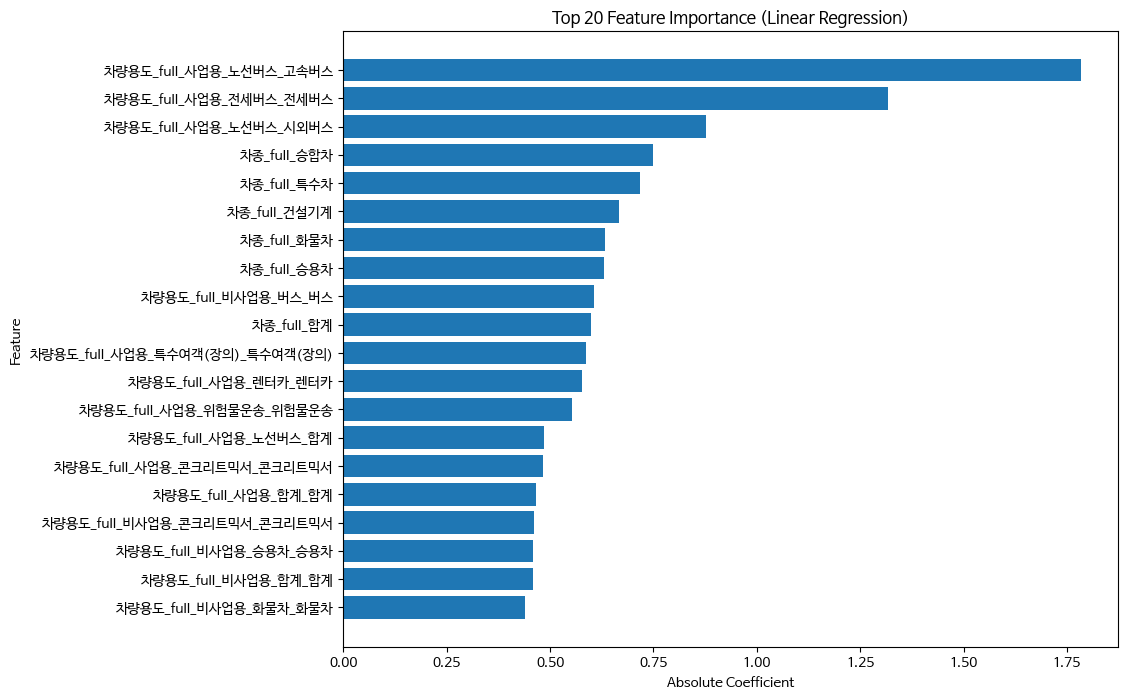

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1️⃣ LinearRegression
# =========================
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# train set pred
y_train_pred_lr = lr_model.predict(X_train)
mse_train_lr = mean_squared_error(y_train, y_train_pred_lr)
r2_train_lr = r2_score(y_train, y_train_pred_lr)

# test set pred
y_test_pred_lr = lr_model.predict(X_test)
mse_test_lr = mean_squared_error(y_test, y_test_pred_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)

print("Linear Regression")
print(f"Train - MSE: {mse_train_lr:.4f}, R2: {r2_train_lr:.4f}")
print(f"Test  - MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}")

lr_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': abs(lr_model.coef_)
}).sort_values(by='importance', ascending=False)

print("Linear Regression Top 10 Feature Importance:")
print(lr_feature_importance.head(10))


top_n = 20
plt.figure(figsize=(10,8))
plt.barh(lr_feature_importance['feature'].head(top_n)[::-1], lr_feature_importance['importance'].head(top_n)[::-1])
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance (Linear Regression)')
plt.show()


Random Forest Regression
Train - MSE: 0.0115, R2: 0.9536
Test  - MSE: 0.0076, R2: 0.9373
Random Forest Top 10 Feature Importance:
                            feature  importance
0                                연도    0.362708
36          차량용도_full_사업용_노선버스_고속버스    0.159786
46          차량용도_full_사업용_전세버스_전세버스    0.071387
53  차량용도_full_사업용_특수여객(장의)_특수여객(장의)    0.021933
39          차량용도_full_사업용_노선버스_시외버스    0.020703
57           차량용도_full_사업용_화물차_일반화물    0.018531
55           차량용도_full_사업용_화물차_개별화물    0.017950
56           차량용도_full_사업용_화물차_용달화물    0.017291
29         차량용도_full_비사업용_컨테이너_컨테이너    0.016699
45        차량용도_full_사업용_위험물운송_위험물운송    0.016501


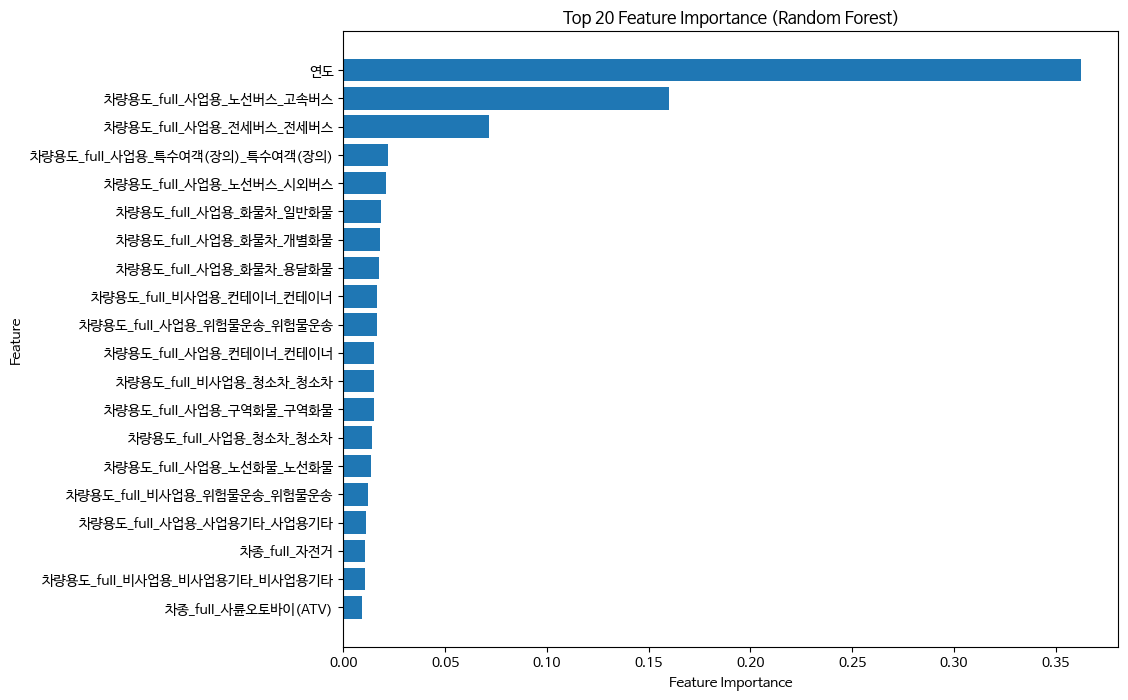

In [10]:
# =========================
# 2️⃣ RandomForestRegressor
# =========================
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# train set pred
y_train_pred_rf = rf_model.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# test set pred
y_test_pred_rf = rf_model.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print("\nRandom Forest Regression")
print(f"Train - MSE: {mse_train_rf:.4f}, R2: {r2_train_rf:.4f}")
print(f"Test  - MSE: {mse_test_rf:.4f}, R2: {r2_test_rf:.4f}")


rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Random Forest Top 10 Feature Importance:")
print(rf_feature_importance.head(10))

# 可视化前20个特征
plt.figure(figsize=(10,8))
plt.barh(rf_feature_importance['feature'].head(top_n)[::-1], rf_feature_importance['importance'].head(top_n)[::-1])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance (Random Forest)')
plt.show()